In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Feb 16 09:35:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    52W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 5.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=8a73b2ca4bf647c6ffeada36da44e8f0c29d3fae1ae84a28e520fab99d181036
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
!pip install pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.0 MB/s eta 0:00:00


In [3]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/PHD_2022/SAC/ICUFN-2023/')  #Root folder
sys.path.insert(0,'/content/drive/MyDrive/PHD_2022/SAC/ICUFN-2023/utils/') # Libraries folder

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle as pkl

from utils import map_vis_without_lanelet

from sklearn.preprocessing import StandardScaler

# EXPERIMENT PARAMETERS
in_timesteps = 10
out_timesteps = 10
in_features = 5
out_features = 2

# Run name
wandb_project_name = "ICUFN-intersection"

train_dataset_path = "/content/drive/MyDrive/PHD_2022/SAC/ICUFN-2023/data/50m-DR_USA_Intersection_MA/50m-6c-DR_USA_Intersection_MA_test.csv"
test_dataset_path = '/content/drive/MyDrive/PHD_2022/SAC/ICUFN-2023/data/50m-DR_USA_Intersection_MA/50m-6c-DR_USA_Intersection_MA_test.csv'

scaler_save_path = '/content/drive/MyDrive/PHD_2022/SAC/ICUFN-2023/models/50m-6c-baseline/scaler.pkl'
scaler_reload_path = '/content/drive/MyDrive/PHD_2022/SAC/ICUFN-2023/models/50m-6c-baseline/scaler.pkl'

model_save_path = '/content/drive/MyDrive/PHD_2022/SAC/ICUFN-2023/models/50m-6c-baseline/'
model_reload_path = '/content/drive/MyDrive/PHD_2022/SAC/ICUFN-2023/models/50m-6c-baseline/'

csv_out_path_train = '/content/drive/MyDrive/PHD_2022/SAC/ICUFN-2023/models/50m-6c-baseline-train.csv'
csv_out_path_test = '/content/drive/MyDrive/PHD_2022/SAC/ICUFN-2023/models/50m-6c-baseline-test.csv'

map_path = "/content/drive/MyDrive/PHD_2022/SAC/ICUFN-2023/data/maps/DR_USA_Intersection_MA.osm"



**METRICS**

In [4]:
# ADE function (single)

import math
def average_displacement_error(pred,ground):

    e = []

    for p,g in zip(pred,ground):
        e.append( math.sqrt (((p[0] - g[0]) ** 2) + ((p[1] - g[1]) ** 2)))

    return np.sum(e)/len(e),e[len(e)-1]   #ADE,FDE

# ADE function over BATCH (mean)

def calculate_error_batch(results, ground):

    ade = []
    fde = [] 

    for r, g in zip(results, ground):
        a,f = average_displacement_error(r,g)
        ade.append(a)
        fde.append(f)
    
    return np.sum(ade)/len(ade), np.sum(fde)/len(fde)


In [5]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project=wandb_project_name)

#wandb
wandb_callback = WandbCallback(monitor='val_loss', mode='min', log_gradients=False,save_model=False)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


**START**

In [5]:
# Load clustered dataset
dataframe = pd.read_csv(train_dataset_path, sep=',')
# This is the train dataframe without normalization, it will be needed after to write the results to disk .csv
dataframe_raw = dataframe   

In [6]:
# Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def scale_full_dataframe(dataframe, scaler_reload_path):

    dataframe_scaled = dataframe[["x", "y", "vx", "vy","psi_rad"]]
    dataframe = dataframe.drop(columns=["x", "y", "vx", "vy","psi_rad"], axis=1) # Keep only meta-data features

    if scaler_reload_path is not None: # if this is test set
        scaler = pd.read_pickle(scaler_reload_path)
    else:
        scaler = MinMaxScaler()
 #       scaler = StandardScaler()

    dataframe_scaled = pd.DataFrame(scaler.fit_transform(dataframe_scaled), columns=["x", "y", "vx", "vy","psi_rad"])

    dataframe = pd.concat([dataframe, dataframe_scaled], axis=1)
    
    if scaler_reload_path is None:  # if this is training set save scaler to file
        # Save scaler to file
        
        with open(scaler_save_path, "wb") as outfile:
            pkl.dump(scaler, outfile)

    return dataframe


In [7]:
# Not sending a pre-calculated scaler because this is training set
# But if you are reloading for evaluating over test send you should send the pre-computed scaler
                                                                                                                                                                        
dataframe = scale_full_dataframe(dataframe, scaler_reload_path = scaler_reload_path)  

In [8]:
def split_groups(dataframe):

    case_id = dataframe.groupby(["case_id", "label"])

    scenary_x = []
    scenary_y = []



    for ix,element in case_id:
        l = element.groupby(["track_id"])
    
        agents = [] # n trajectories (scenary-(aka: cluster)), one per agent

        # Get all scenary-(aka:cluster) trajectories
        for ig, eg in l:
            feat = eg[["x", "y", "vx", "vy","psi_rad"]]
            f_list = feat.values.tolist()
            agents.append(f_list)
    
        # separate each trajectory

        for tj in agents:
            temp = np.array(tj)
            temp_x = temp[0:in_timesteps,:]  # 0:10,:
            temp_y = temp[in_timesteps:,0:out_features]  # 10:, 0:2 only predict x,y

            d_x = np.hstack((temp_x))
            d_x = d_x.reshape(in_timesteps,1,in_features) # in_timesteps=10, 1= only one car, in_features = 5 features

            d_y = np.hstack((temp_y))
            d_y = d_y.reshape(out_timesteps,1,out_features) # out_timesteps=10, 1=only one car, out_features = 2 features

            scenary_x.append(d_x)
            scenary_y.append(d_y)   

    return np.array(scenary_x),np.array(scenary_y)

In [9]:
scene_x_train,scene_y_train = split_groups(dataframe) # unfold groups

# Print training shape
print(scene_x_train.shape)
print(scene_y_train.shape)

(1242, 10, 1, 5)
(1242, 10, 1, 2)


In [20]:
scene_x_train[0]

array([[[ 9.967670e+02,  1.000307e+03,  4.680000e-01, -3.100000e-02,
         -6.600000e-02]],

       [[ 9.968490e+02,  1.000300e+03,  2.620000e-01, -1.800000e-02,
         -6.700000e-02]],

       [[ 9.968990e+02,  1.000296e+03,  0.000000e+00,  0.000000e+00,
         -6.700000e-02]],

       [[ 9.968990e+02,  1.000296e+03,  0.000000e+00,  0.000000e+00,
         -6.700000e-02]],

       [[ 9.968990e+02,  1.000296e+03,  0.000000e+00,  0.000000e+00,
         -6.700000e-02]],

       [[ 9.968990e+02,  1.000296e+03,  0.000000e+00,  0.000000e+00,
         -6.700000e-02]],

       [[ 9.968990e+02,  1.000296e+03,  0.000000e+00,  0.000000e+00,
         -6.700000e-02]],

       [[ 9.968990e+02,  1.000296e+03,  0.000000e+00,  0.000000e+00,
         -6.700000e-02]],

       [[ 9.968990e+02,  1.000296e+03,  0.000000e+00,  0.000000e+00,
         -6.700000e-02]],

       [[ 9.968990e+02,  1.000296e+03,  0.000000e+00,  0.000000e+00,
         -6.700000e-02]]])

In [11]:
scene_x_train[0]

array([[[0.21272085, 0.49721558, 0.46733077, 0.51513811, 0.48949714]],

       [[0.21344817, 0.49711163, 0.46020546, 0.51566081, 0.489338  ]],

       [[0.21389165, 0.49705223, 0.45114316, 0.51638454, 0.489338  ]],

       [[0.21389165, 0.49705223, 0.45114316, 0.51638454, 0.489338  ]],

       [[0.21389165, 0.49705223, 0.45114316, 0.51638454, 0.489338  ]],

       [[0.21389165, 0.49705223, 0.45114316, 0.51638454, 0.489338  ]],

       [[0.21389165, 0.49705223, 0.45114316, 0.51638454, 0.489338  ]],

       [[0.21389165, 0.49705223, 0.45114316, 0.51638454, 0.489338  ]],

       [[0.21389165, 0.49705223, 0.45114316, 0.51638454, 0.489338  ]],

       [[0.21389165, 0.49705223, 0.45114316, 0.51638454, 0.489338  ]]])

In [10]:
def to_single_agent_predictor(scene_x_train,scene_y_train):

    # Split dataset to be used as single agent model predictor, remove single group dimension

    n_samples_train = scene_x_train.shape[0]

    #scene_x_train = tf.transpose(scene_x_train, [2, 0, 1, 3])
    scene_x_train = np.transpose(scene_x_train,(2,0,1,3))

    #scene_x_train = tf.reshape(scene_x_train, (n_samples_train * 1, in_timesteps, in_features))  #batch*nodes, seq_len, feat
    scene_x_train = np.reshape(scene_x_train, (n_samples_train * 1, in_timesteps, in_features))  #batch*nodes, seq_len, feat

    #scene_y_train = tf.transpose(scene_y_train, [2, 0, 1, 3])
    scene_y_train = np.transpose(scene_y_train, (2, 0, 1, 3))

 #   scene_y_train = tf.reshape(scene_y_train, (n_samples_train * 1, out_timesteps, out_features))  #batch*nodes, seq_len, feat =  2, only predict x,y
    scene_y_train = np.reshape(scene_y_train, (n_samples_train * 1, out_timesteps, out_features))  #batch*nodes, seq_len, feat =  2, only predict x,y

    print(scene_x_train.shape)
    print(scene_y_train.shape)

    return scene_x_train, scene_y_train


In [11]:
scene_x_train, scene_y_train =  to_single_agent_predictor(scene_x_train,scene_y_train)

(1242, 10, 5)
(1242, 10, 2)


In [23]:
scene_x_train[0]

array([[ 9.967670e+02,  1.000307e+03,  4.680000e-01, -3.100000e-02,
        -6.600000e-02],
       [ 9.968490e+02,  1.000300e+03,  2.620000e-01, -1.800000e-02,
        -6.700000e-02],
       [ 9.968990e+02,  1.000296e+03,  0.000000e+00,  0.000000e+00,
        -6.700000e-02],
       [ 9.968990e+02,  1.000296e+03,  0.000000e+00,  0.000000e+00,
        -6.700000e-02],
       [ 9.968990e+02,  1.000296e+03,  0.000000e+00,  0.000000e+00,
        -6.700000e-02],
       [ 9.968990e+02,  1.000296e+03,  0.000000e+00,  0.000000e+00,
        -6.700000e-02],
       [ 9.968990e+02,  1.000296e+03,  0.000000e+00,  0.000000e+00,
        -6.700000e-02],
       [ 9.968990e+02,  1.000296e+03,  0.000000e+00,  0.000000e+00,
        -6.700000e-02],
       [ 9.968990e+02,  1.000296e+03,  0.000000e+00,  0.000000e+00,
        -6.700000e-02],
       [ 9.968990e+02,  1.000296e+03,  0.000000e+00,  0.000000e+00,
        -6.700000e-02]])

In [12]:
from sklearn.utils import shuffle

# Keep a copy of the no shuffle dataset
scene_x_train_no_shuffle = scene_x_train
scene_y_train_no_shuffle = scene_y_train

# Shuffle the dataset, but only on the first axis
scene_x_train, scene_y_train = shuffle(scene_x_train, scene_y_train, random_state=1)

In [13]:
# Display single trajectories

def print_single_trajectory(prev_list,ground_list,prediction_list,n,ix,debug=False,show_map = False, zoom_map = True):
    
    prev = prev_list[ix:ix+n]
    ground = ground_list[ix:ix+n]
    
    if prediction_list is not None:
        pred = prediction_list[ix:ix+n]
    
   
    fig, ax = plt.subplots(1,n,figsize=(40,5))

    fig.set_size_inches(40, 40)
    

    for i,p in enumerate(prev):

        # Display map using library provided without lanelet lib
        if (show_map == True):
            map_vis_without_lanelet.draw_map_without_lanelet(map_path, ax[i], 0.0, 0.0)

        
        g = ground[i]
        

        p = tf.transpose(p,[1,0]) 
        g = tf.transpose(g,[1,0])      

        ax[i].set_aspect('equal')
        ax[i].plot(p[0], p[1],'-o',color='gray',linestyle='solid', linewidth=2,zorder=100)
        ax[i].plot(g[0], g[1],'-o',color='deepskyblue',linestyle='solid',linewidth=2,zorder=100)

        # x_coord and y_coord will be useful to calculate limit range of the map
        x_coord = np.concatenate((p.numpy()[0,:],g.numpy()[0,:],g.numpy()[0,:]),axis=0) # join all xs
        y_coord = np.concatenate((p.numpy()[1,:],g.numpy()[1,:],g.numpy()[1,:]),axis=0) # join all ys

        if prediction_list is not None:
            r = pred[i]
            r = tf.transpose(r,[1,0])
            ax[i].plot(r[0], r[1],'-o',color='darkmagenta',linestyle='solid',linewidth=2, zorder=100)
            print("ADE(m), FDE(m):", average_displacement_error(r.numpy(),g.numpy())) # Difference between predicted and ground truth

            # Join the r results to have a true zoom range
            x_coord = np.concatenate((x_coord,r.numpy()[0,:]),axis=0) # join all xs
            y_coord = np.concatenate((y_coord,r.numpy()[1,:]),axis=0) # join all ys
                  
        if (debug):
            print("forecasted: ", r.numpy())
            print("truth: ", g.numpy())       

     


        # Limit the visible area of the plot
        if( zoom_map == True):

            # Calculate maxs and mins
            max_x = np.amax(x_coord)
            min_x = np.amin(x_coord)
            max_y = np.amax(y_coord)
            min_y = np.amin(y_coord)
            
            # Set limits
            ax[i].set_xlim([min_x -10 , max_x + 10])
            ax[i].set_ylim([min_y -10 , max_y + 10])


    plt.show()

In [14]:
# Display single trajectories

def print_single_cluster(prev_list,ground_list,prediction_list,n,ix,debug=False,show_map = False, zoom_map = True):
    
    prev = prev_list[ix:ix+n]
    ground = ground_list[ix:ix+n]
    
    if prediction_list is not None:
        pred = prediction_list[ix:ix+n]
    
   
    #fig, ax = plt.subplots(1,n,figsize=(40,5))
    fig, ax = plt.subplots(1,1,figsize=(40,5))

    fig.set_size_inches(40, 40)
    

    for i,p in enumerate(prev):

        # Display map using library provided without lanelet lib
        if (show_map == True):
            map_vis_without_lanelet.draw_map_without_lanelet(map_path, ax, 0.0, 0.0)

        
        g = ground[i]
        

        p = tf.transpose(p,[1,0]) 
        g = tf.transpose(g,[1,0])      

        ax.set_aspect('equal')
        ax.plot(p[0], p[1],'-x',color='gray',linestyle='solid', linewidth=3, zorder=100)
        ax.plot(g[0], g[1],'-',color='navy',linestyle='solid', linewidth=3, zorder=100)

        # x_coord and y_coord will be useful to calculate limit range of the map
        x_coord = np.concatenate((p.numpy()[0,:],g.numpy()[0,:],g.numpy()[0,:]),axis=0) # join all xs
        y_coord = np.concatenate((p.numpy()[1,:],g.numpy()[1,:],g.numpy()[1,:]),axis=0) # join all ys

        if prediction_list is not None:
            r = pred[i]
            r = tf.transpose(r,[1,0])
            ax.plot(r[0], r[1],'-',color='darkmagenta',linestyle='solid',linewidth=3,zorder=100)
            print("ADE(m), FDE(m):", average_displacement_error(r.numpy(),g.numpy())) # Difference between predicted and ground truth

            # Join the r results to have a true zoom range
            x_coord = np.concatenate((x_coord,r.numpy()[0,:]),axis=0) # join all xs
            y_coord = np.concatenate((y_coord,r.numpy()[1,:]),axis=0) # join all ys
                  
        if (debug):
            print("forecasted: ", r.numpy())
            print("truth: ", g.numpy())       

     


        # Limit the visible area of the plot
        if( zoom_map == True):

            # Calculate maxs and mins
            max_x = np.amax(x_coord)
            min_x = np.amin(x_coord)
            max_y = np.amax(y_coord)
            min_y = np.amin(y_coord)
            
            # Set limits
            ax.set_xlim([min_x -10 , max_x + 10])
            ax.set_ylim([min_y -10 , max_y + 10])


    plt.show()

In [ ]:
print_single_cluster(scene_x_train,scene_y_train,None,6,690,show_map=True, zoom_map=False)

In [ ]:
print_single_trajectory(scene_x_train,scene_y_train,None,2,0,show_map=False, zoom_map=False)

In [15]:
import tensorflow as tf

input_layer = tf.keras.Input(shape=(in_timesteps,in_features)) # in_seq_len = 10, in_features = 5

encoder = tf.keras.layers.LSTM(1024, return_sequences=False)(input_layer)
latent_vector = tf.keras.layers.RepeatVector(10)(encoder)  #  RepeatVector = 10 = out_timesteps  !Attention
decoder = tf.keras.layers.LSTM(1024, return_sequences=True)(latent_vector)
decoder_last = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=out_features, activation='relu'))(decoder) # units= 2 because we are only predicting x,y

model = tf.keras.Model(input_layer, decoder_last)

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['mse', 'mae']) #0.00003

#uncomment this line to show model summary
#print(model.summary())

In [16]:
# !!!IMPORTANT!!! only uncomment and run this line to load a pre-trained model file for re-training or evaluating 
model = tf.keras.models.load_model(model_reload_path)

In [17]:
# early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.00000000000001, patience=30, mode='min', restore_best_weights=True) #0.00005

# callbacks
callbacks_list = [wandb_callback,early_stopping_callback]

In [18]:
# Model training
from sklearn.utils import shuffle
model.fit(
    scene_x_train, scene_y_train, 
    validation_split=0.3,
    batch_size = 64, #128
    epochs=4000,  #1000
    shuffle = True,
    callbacks=callbacks_list,
)

Epoch 1/4000
14/14 [==============================] - 10s 74ms/step - loss: 0.0961 - mse: 0.0961 - mae: 0.2477 - val_loss: 0.0353 - val_mse: 0.0353 - val_mae: 0.1406
Epoch 2/4000
14/14 [==============================] - 0s 12ms/step - loss: 0.0302 - mse: 0.0302 - mae: 0.1291 - val_loss: 0.0221 - val_mse: 0.0221 - val_mae: 0.1146
Epoch 3/4000
14/14 [==============================] - 0s 13ms/step - loss: 0.0158 - mse: 0.0158 - mae: 0.0873 - val_loss: 0.0112 - val_mse: 0.0112 - val_mae: 0.0708
Epoch 4/4000
14/14 [==============================] - 0s 12ms/step - loss: 0.0097 - mse: 0.0097 - mae: 0.0703 - val_loss: 0.0088 - val_mse: 0.0088 - val_mae: 0.0674
Epoch 5/4000
14/14 [==============================] - 0s 13ms/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0624 - val_loss: 0.0067 - val_mse: 0.0067 - val_mae: 0.0572
Epoch 6/4000
14/14 [==============================] - 0s 12ms/step - loss: 0.0059 - mse: 0.0059 - mae: 0.0531 - val_loss: 0.0054 - val_mse: 0.0054 - val_mae: 0.0509
Epoch 7/4

In [19]:
# save the model in tensorflow format
model.save(model_save_path)

**EVALUATION OF MODEL'S PERFORMANCE**

**TRAINING EVALUATION**

In [17]:
# Evaluate to get MSE error over training set
y_pred = model.evaluate(scene_x_train,scene_y_train)

39/39 [==============================] - 14s 327ms/step - loss: 8.6239e-05 - mse: 8.6239e-05 - mae: 0.0055


In [18]:
# Predictions over training set (Normalized)

results_train = model.predict(scene_x_train)

# Uncomment if you are interested on calculate ADE over normalized trajectories
#print('Error ADE training (normalized): ',calculate_error_batch(results,scene_y_train))

39/39 [==============================] - 14s 341ms/step


**DE-NORMALIZATION EVALUATION**

In [19]:
# De-normalization to calculate metrics in meters scale

def denormalize_x_y_r(scene_x_train,scene_y_train,results,scaler_reload_path):

#    scene_x_train_inv = tf.reshape(scene_x_train, [-1, in_features]).numpy()
    scene_x_train_inv = np.reshape(scene_x_train, (-1, in_features)) #.numpy()

#    scene_y_train_inv = tf.reshape(scene_y_train, [-1, out_features]).numpy()
    scene_y_train_inv = np.reshape(scene_y_train, (-1, out_features)) #.numpy()

    
    results_inv = np.reshape(results, (-1,out_features))



    # Reload Original Scaler Train with all features
    scaler =  pd.read_pickle(scaler_reload_path) 

    # Create a new scaler only for x,y features, because the first scaler contains all the input features
#    scaler_feat = StandardScaler()
    scaler_feat  = MinMaxScaler()

    scaler_feat.n_features_in=out_features
    scaler_feat.min_,scaler_feat.scale_= [scaler.min_[0],scaler.min_[1]],[scaler.scale_[0],scaler.scale_[1]]
#    scaler_feat.var_,scaler_feat.mean_,scaler_feat.scale_= [scaler.var_[0],scaler.var_[1]],[scaler.mean_[0],scaler.mean_[1]],[scaler.scale_[0],scaler.scale_[1]]

    results_inv = scaler_feat.inverse_transform(results_inv)
    scene_x_train_inv = scaler.inverse_transform(scene_x_train_inv)   #Attention to make use of original full scaler with 5 features
    scene_y_train_inv = scaler_feat.inverse_transform(scene_y_train_inv)

    results_inv = np.reshape(results_inv, (-1,out_timesteps,out_features)) #n_samples,timesteps=10,out features=2
    scene_y_train_inv = np.reshape(scene_y_train_inv,(-1,out_timesteps,out_features)) #n_samples,timesteps=10,out features=2
    scene_x_train_inv = np.reshape(scene_x_train_inv, (-1,in_timesteps,in_features))  #Attention to use the orginal 5 features from original X
    
    
    return scene_x_train_inv, scene_y_train_inv, results_inv

In [20]:
scene_x_train_inv,scene_y_train_inv,results_train_inv = denormalize_x_y_r(scene_x_train,scene_y_train,results_train,scaler_reload_path)

ADE(m), FDE(m): (0.007765450831303937, 0.0070708328497302055)
ADE(m), FDE(m): (0.014921677128891841, 0.017260180720436114)


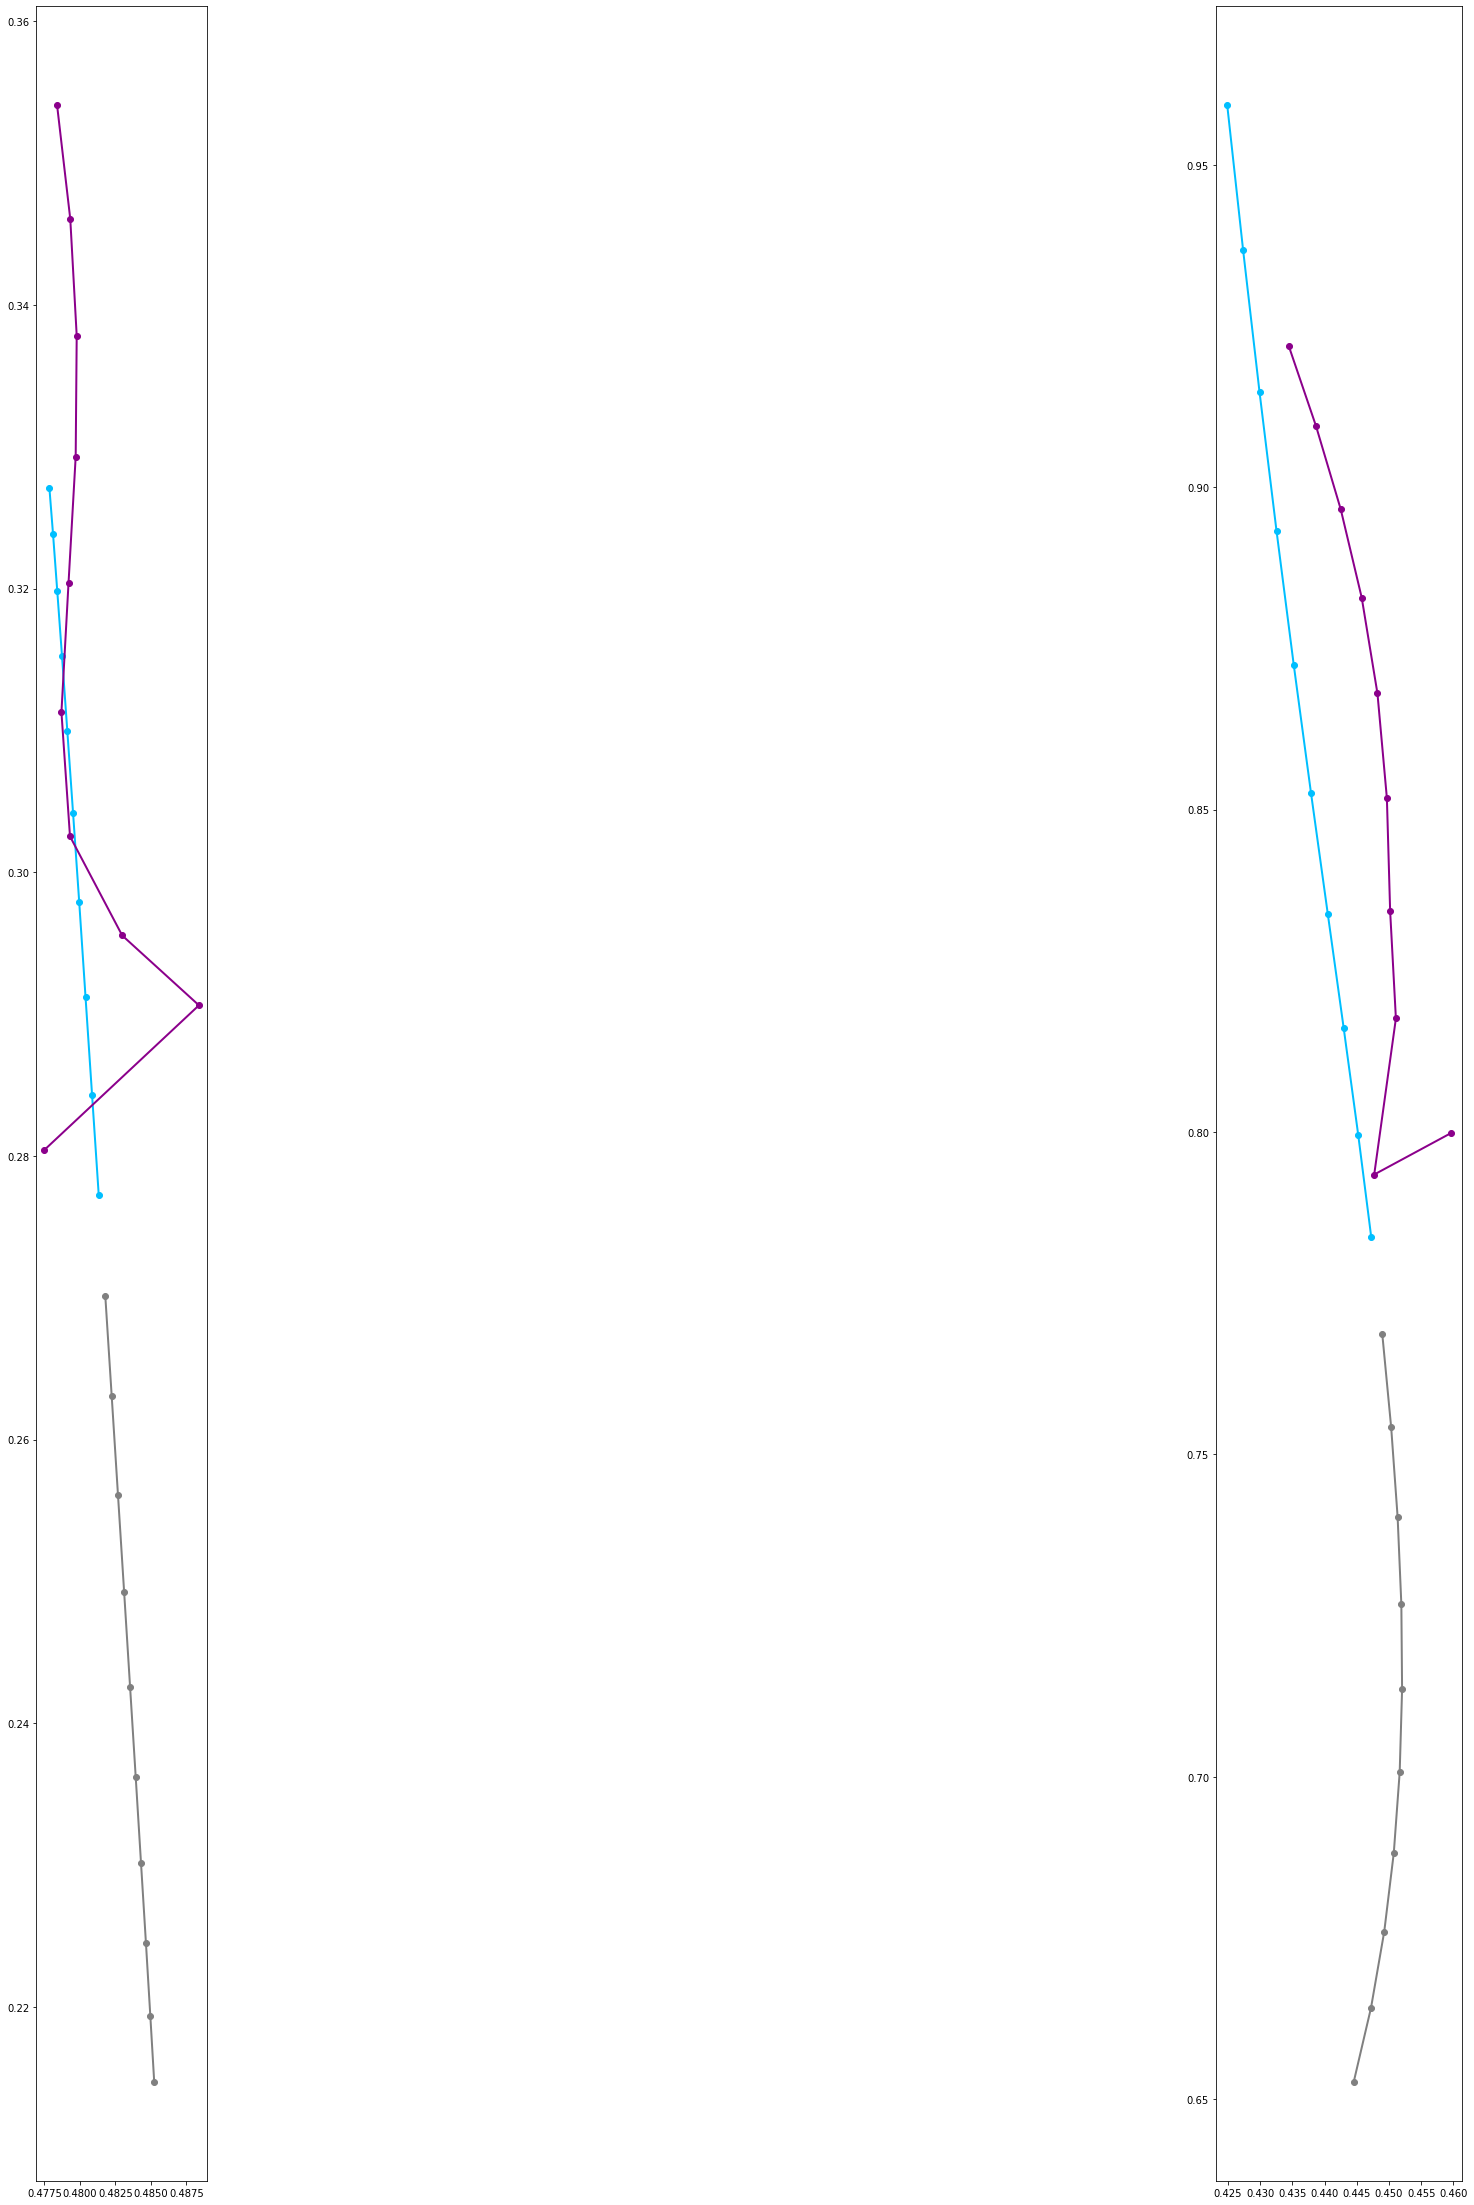

In [26]:
print_single_trajectory(scene_x_train,scene_y_train, results_train,2,0, show_map=False, zoom_map = False)

ADE(m), FDE(m): (0.714963459175751, 0.4761502963333786)
ADE(m), FDE(m): (1.2904938661805936, 1.1622862657595414)


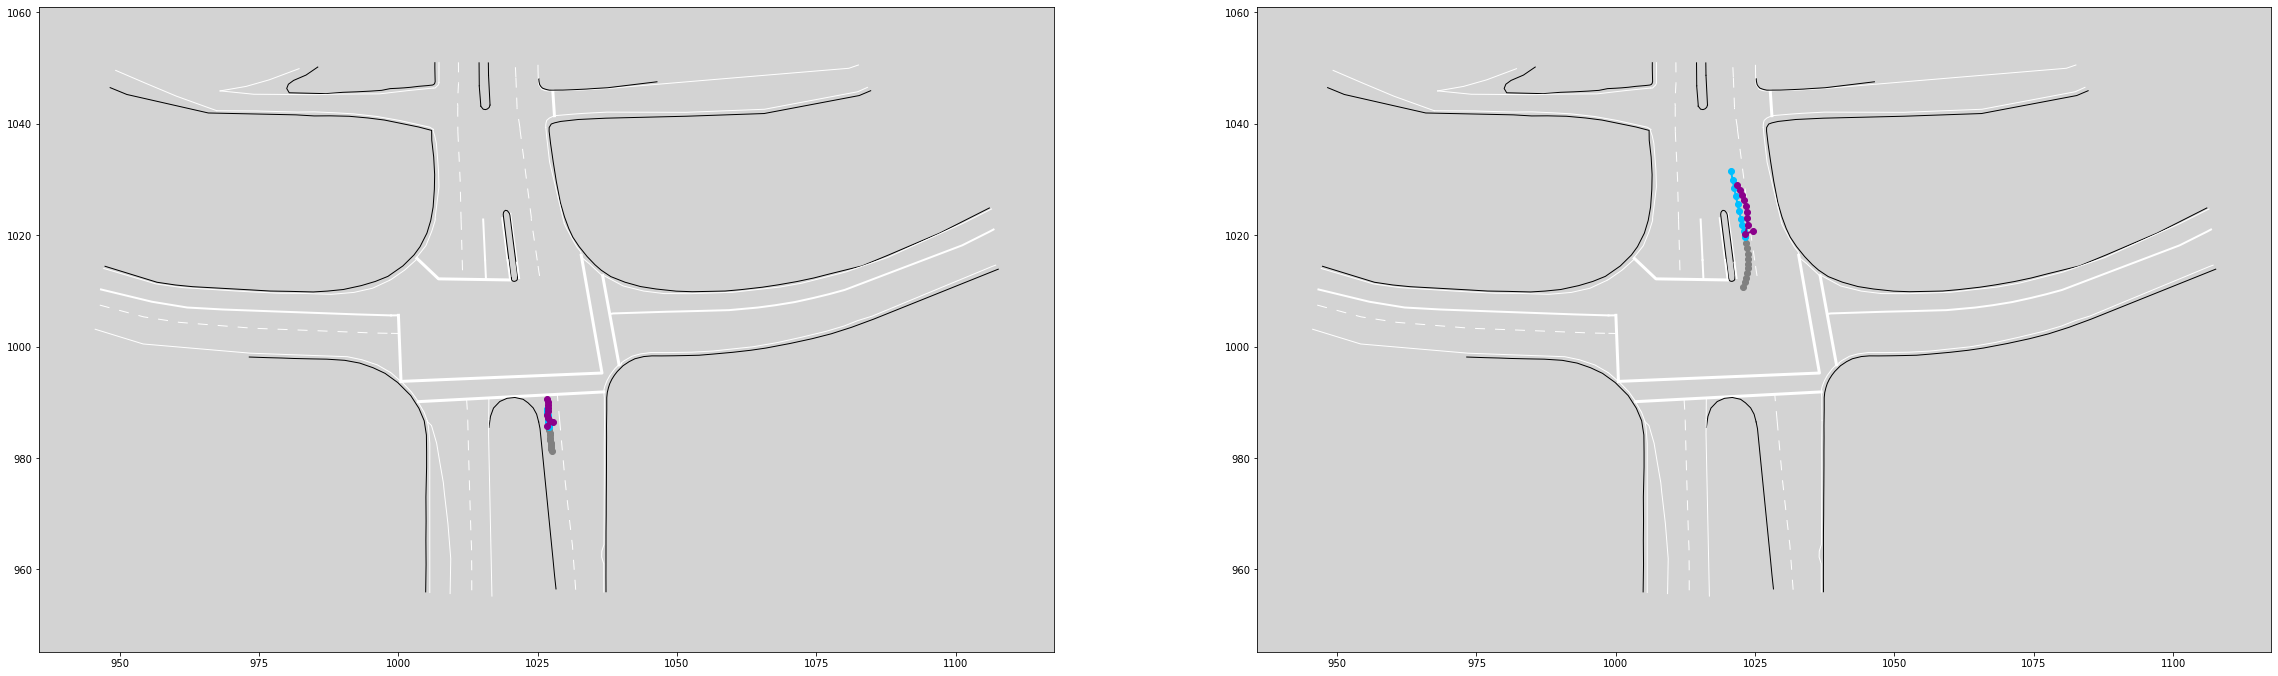

In [25]:
print_single_trajectory(scene_x_train_inv,scene_y_train_inv, results_train_inv,2,0, show_map=True, zoom_map = False)

In [27]:
print("Train error ADE(m), FDE(m): ",calculate_error_batch(results_train_inv,scene_y_train_inv)) # Error in meters (De-normalized)

Train error ADE(m), FDE(m):  (0.7599995063126078, 1.6195854143467199)


In [ ]:
# Examples of predictions over training, (note the equal graphs for norm and de-norm trajectories)
print_single_trajectory(scene_x_train,scene_y_train, results_train, 2,401,zoom_map=False)  # n,index

In [ ]:
print_single_trajectory(scene_x_train_inv,scene_y_train_inv, results_train_inv,3,400,show_map=True,zoom_map=True) # n,index

In [ ]:
# Write train predictions to file
def write_to_csv(scene_x_train_inv,results_train_inv,dataframe_raw,csv_out_path):
    scene_x_train_inv_xy = scene_x_train_inv[:, :, 0:2] # Take only x and y features
    # add the ground truth to predicted trajectory
    df_results = np.concatenate((scene_x_train_inv_xy, results_train_inv), axis=1)
    # convert the 3D object to a 2D object
    df_results = np.reshape(df_results,(-1,2))
    df_results = pd.DataFrame(data = df_results,columns = ['x_','y_'])
    # concatenate the predictions and ground truths with meta-data (case_id, track_id,label)
    results_merged = pd.concat([dataframe_raw, df_results], axis=1,ignore_index=False)  # merge along columns

    #write results to .csv file
    results_merged.to_csv(csv_out_path,  index = False)

    return results_merged

In [ ]:
# Write to .csv file
r = write_to_csv(scene_x_train_inv, results_train_inv, dataframe_raw,csv_out_path_train)

# writed datafreme to file
r.describe()

,case_id,track_id,frame_id,timestamp_ms,x,y,vx,vy,psi_rad,length,width,label,x_,y_
count,635560.00000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000,635560.00000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000
mean,2634.16096,7.163730,20.000000,2000.000000,1018.105851,1003.645663,1.60804,-0.084499,-0.196957,4.503195,1.733667,0.493801,1018.061610,1003.656715
std,1459.69109,4.006838,11.532572,1153.257167,22.522870,9.534795,4.01982,2.041666,1.517198,0.602154,0.203770,0.646093,22.526170,9.532079
min,1.00000,1.000000,1.000000,100.000000,972.187000,964.518000,-15.58800,-14.836000,-3.142000,2.660000,1.350000,0.000000,972.187000,964.518000
25%,1356.00000,4.000000,10.500000,1050.000000,998.217000,1000.439000,-0.02200,-0.212000,-1.430000,4.230000,1.560000,0.000000,998.162643,1000.443115
50%,2728.00000,7.000000,20.000000,2000.000000,1016.885000,1003.893000,0.21000,-0.017000,-0.033000,4.450000,1.650000,0.000000,1016.855000,1003.909241
75%,4006.00000,10.000000,29.500000,2950.000000,1031.413000,1007.871000,2.85800,0.094000,0.098000,4.690000,1.910000,1.000000,1031.408000,1007.886292
max,5163.00000,24.000000,39.000000,3900.000000,1088.321000,1034.248000,17.87600,13.540000,3.142000,12.200000,2.600000,5.000000,1089.254272,1034.303223


**TEST EVALUATION**

In [ ]:
# EVALUATE ON TEST SET

# Load clustered dataset
dataframe = pd.read_csv(test_dataset_path, sep=',')
# This is the test dataframe without normalization, it will be needed after to write the results to disk .csv
dataframe_raw = dataframe   

# Scale all test dataset
dataframe = scale_full_dataframe(dataframe, scaler_reload_path = scaler_reload_path)  # send a pre-calculated scaler because this is test set

# Separate clusters (flat)
scene_x_test,scene_y_test = split_groups(dataframe)

# Convert clusters to single agent arrays
scene_x_test,scene_y_test =  to_single_agent_predictor(scene_x_test,scene_y_test)

(1242, 10, 5)
(1242, 10, 2)


In [ ]:
results_test = model.predict(scene_x_test)
# Uncomment if you are interested on calculate ADE over normalized trajectories
#calculate_error_batch(results,scene_y_test)

39/39 [==============================] - 1s 11ms/step


In [ ]:
scene_x_test_inv,scene_y_test_inv,results_test_inv = denormalize_x_y_r(scene_x_test,scene_y_test,results_test,scaler_reload_path)

In [ ]:
print("Test error ADE(m), FDE(m): ", calculate_error_batch(results_test_inv,scene_y_test_inv)) # Error in meters (De-normalized)

Test error ADE(m), FDE(m):  (2.306831509392191, 3.685535788521978)


ADE(m), FDE(m): (0.012676313168577735, 0.009811407131834012)
ADE(m), FDE(m): (0.013421760136808849, 0.011041326080751389)


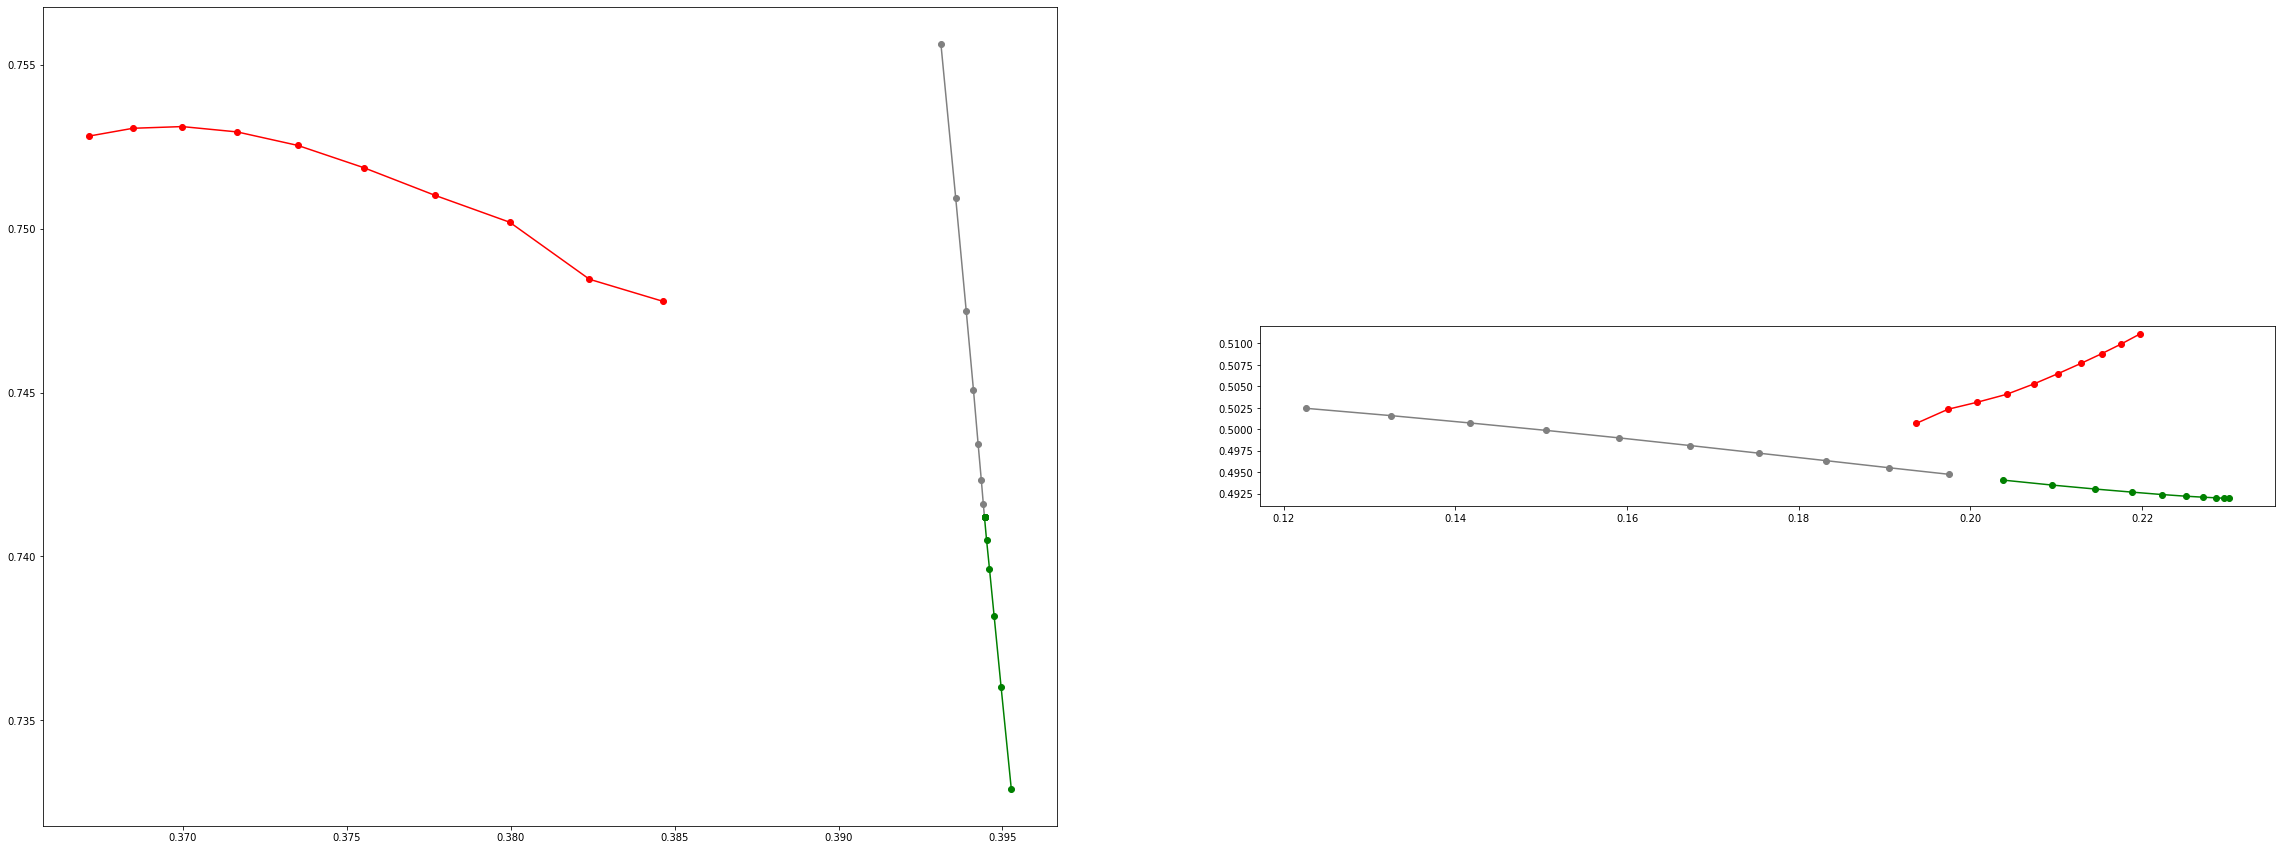

In [ ]:
# This maybe is not useful for human reading as the scale is normalized
print_single_trajectory(scene_x_test,scene_y_test, results_test,2,100, show_map=False, zoom_map = False)

ADE(m), FDE(m): (1.2241674688665976, 0.6534271411822659)
ADE(m), FDE(m): (1.2802093639977004, 0.7353603704952917)


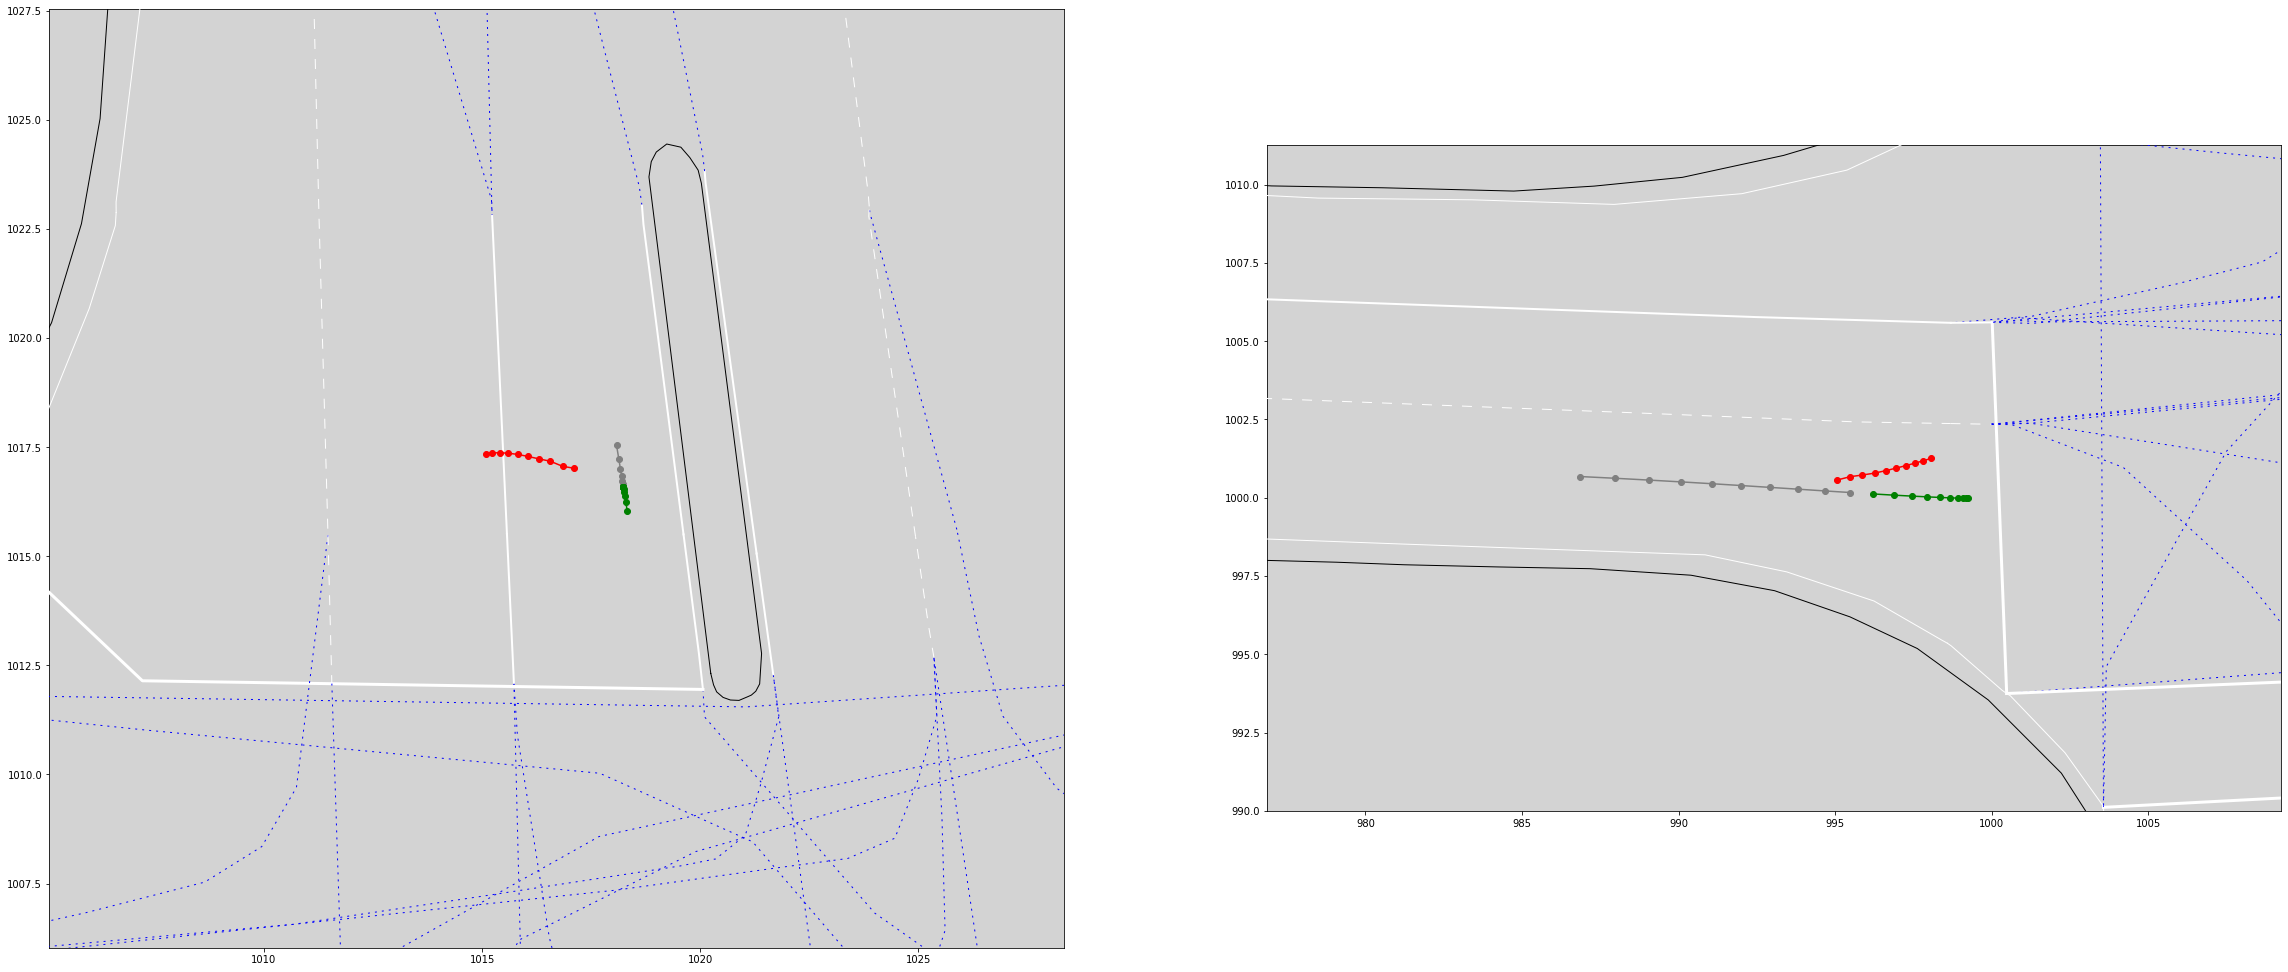

In [ ]:
print_single_trajectory(scene_x_test_inv,scene_y_test_inv, results_test_inv,2,100,debug=False,show_map=True, zoom_map = True)

ADE(m), FDE(m): (1.2241674688665976, 0.6534271411822659)
ADE(m), FDE(m): (1.2802093639977004, 0.7353603704952917)


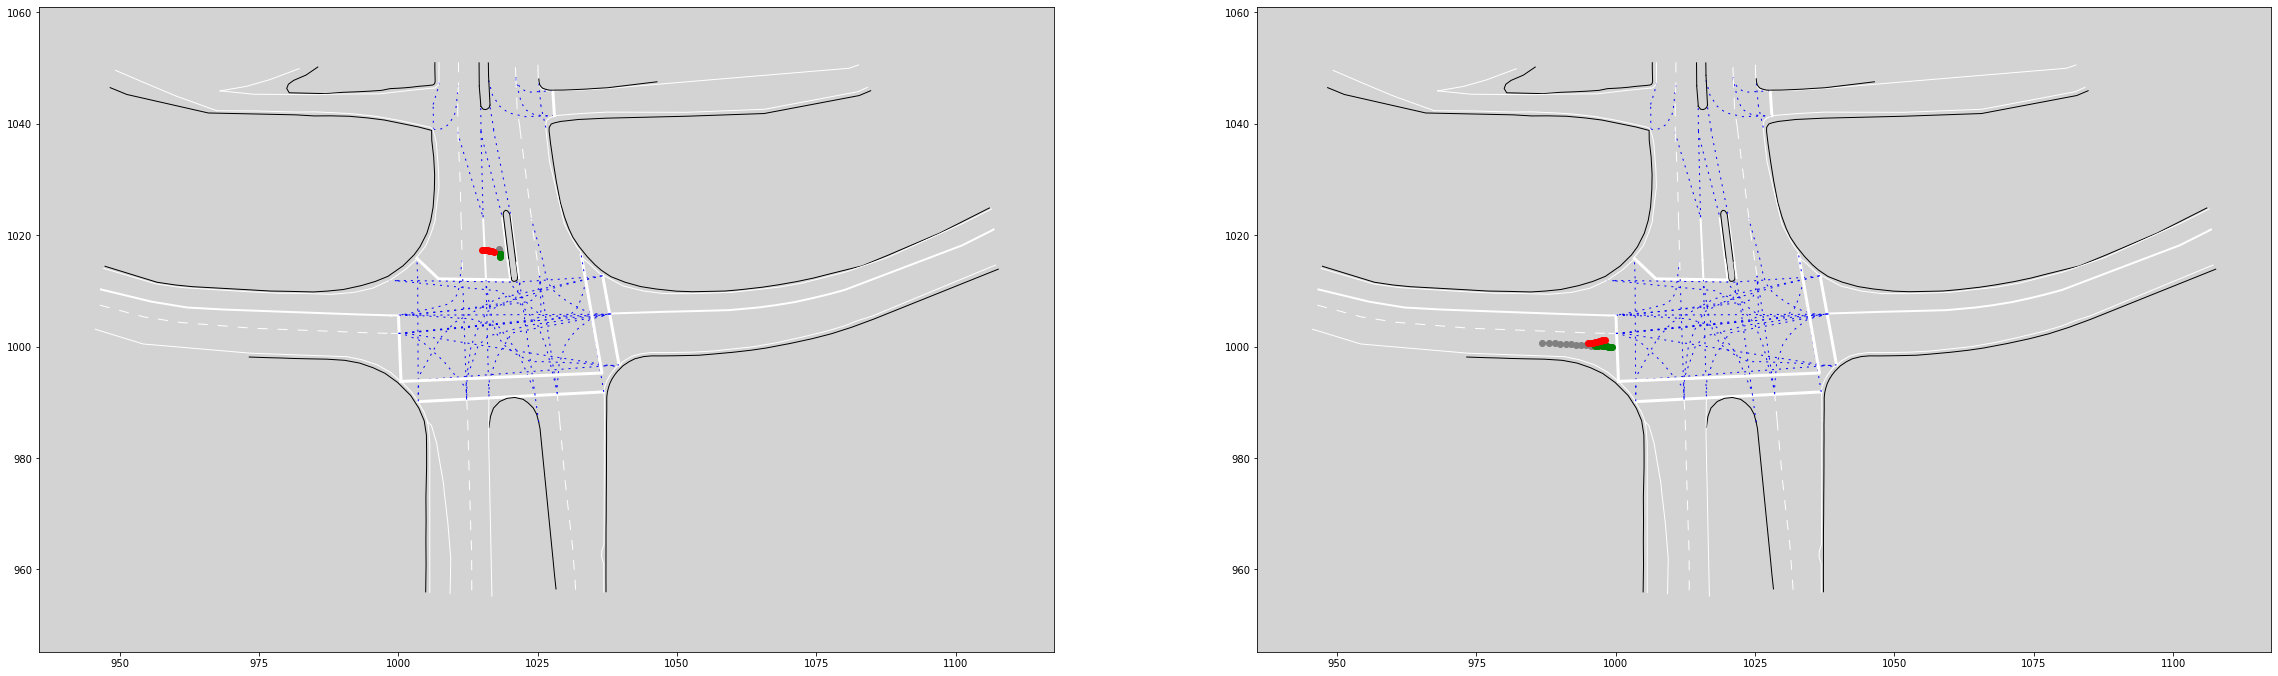

In [ ]:
print_single_trajectory(scene_x_test_inv,scene_y_test_inv, results_test_inv,2,100,debug=False,show_map=True, zoom_map = False)

In [ ]:
# Write test predictions to .csv file
r = write_to_csv(scene_x_test_inv, results_test_inv, dataframe_raw,csv_out_path_test)

# writed datafreme to file
r.describe()

,case_id,track_id,frame_id,timestamp_ms,x,y,vx,vy,psi_rad,length,width,label,x_,y_
count,169000.000000,169000.000000,169000.000000,169000.000000,169000.000000,169000.000000,169000.000000,169000.000000,169000.000000,169000.000000,169000.000000,169000.000000,169000.000000,169000.000000
mean,2555.860237,7.116095,20.000000,2000.000000,1018.053928,1003.596227,1.592749,-0.055653,-0.191354,4.517295,1.741914,0.498343,1017.401191,1002.900705
std,1473.198442,3.886890,11.532597,1153.259671,22.667016,9.499189,4.024034,2.069373,1.520074,0.593123,0.205847,0.649670,22.785222,9.545722
min,2.000000,1.000000,1.000000,100.000000,972.599000,965.004000,-14.315000,-13.491000,-3.142000,2.660000,1.350000,0.000000,972.187000,964.518000
25%,1227.000000,4.000000,10.500000,1050.000000,998.129750,1000.464000,-0.032000,-0.208000,-1.427000,4.240000,1.570000,0.000000,997.424924,999.792811
50%,2729.000000,7.000000,20.000000,2000.000000,1016.904000,1003.890000,0.219000,-0.018000,-0.032000,4.460000,1.660000,0.000000,1016.202820,1003.142731
75%,3839.000000,10.000000,29.500000,2950.000000,1031.604250,1007.837000,2.813250,0.108250,0.103000,4.700000,1.910000,1.000000,1031.297604,1007.286777
max,5156.000000,23.000000,39.000000,3900.000000,1087.974000,1034.511000,18.688000,14.200000,3.142000,12.200000,2.600000,4.000000,1088.266645,1034.248000
